In [1]:
include("c:/Users/vikra/OneDrive/Desktop/project/src/QuantumDD/QuantumDD.jl")
cd("c:/Users/vikra/OneDrive/Desktop/project")
using Pkg
Pkg.activate(".")
using .QuantumDD, Plots, LsqFit, FFTW, QuantumToolbox

  Activating project at `c:\Users\vikra\OneDrive\Desktop\project`


┌ Info: Simulating FID
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:16
Simulating 100%|█████████████████████████████████████████| Time: 0:00:04
┌ Info: T2* for FID: 0.10253056723622482
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:39
┌ Info: Simulating CPMG with 50 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:43
Simulating 100%|█████████████████████████████████████████| Time: 0:02:30
┌ Info: T2_eff for CPMG with 50 pulses: 0.11078781662392898
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W6sZmlsZQ==.jl:66
┌ Info: Simulating CPMG with 200 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn ech

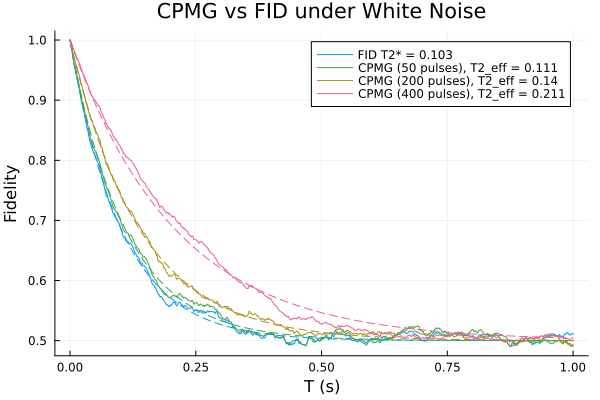

In [ ]:
using Printf
sequence = "CPMG"
T_max = 1.0
n_realizations = 1000
dt = 1e-3   # Time step for simulation
pulse_duration = dt # Pulse duration can't be smaller than dt
σ = 0.2
pulse_shape = "square"
ψ₀ = normalize(basis(2, 0) + basis(2, 1))

# Noise setup
parameters = get_preset_params("white")
S_func = ω -> S(ω; parameters...)

# Run baseline FID
@info "Simulating FID"
T_vals, avg_fid = simulate_shaped_control_fidelity(
    ψ₀ = ψ₀,
    T_max = T_max,
    dt = dt,
    target_std = σ,
    n_realizations = n_realizations,
    S_func_z = S_func,
)

# Start plot with FID

pulse_counts = [50, 200, 400]#, 600, 800, 950]  # Different pulse counts to try
# Defining the fit model
fit_model(t, p) = 0.5 .+ 0.5 .* exp.(-p[1] .* t)
fit_fid = curve_fit(fit_model, T_vals, avg_fid, [0.001])
T2_star = 1/fit_fid.param[1]
plt = plot(T_vals, avg_fid, label="FID T2* = $(@sprintf("%.3g", T2_star))",
            xlabel="T (s)", ylabel="Fidelity")
c = plt.series_list[end].plotattributes[:seriescolor]

plot!(plt, T_vals, fit_model(T_vals, fit_fid.param),
      label=false, linestyle=:dash, color=c)
@info "T2* for FID: $T2_star"

# Simulate CPMG sequences with different pulse counts
for n_pi_pulses in pulse_counts
    @info "Simulating CPMG with $n_pi_pulses pulses"
    control_terms = make_control_terms(sequence, T_max, n_pi_pulses;
        pulse_duration=pulse_duration,
        shape=pulse_shape,
        axis=:x,
        pulse_amplitude=π,
        center_pulse=true
    )

    T_vals_ctrl, avg_fid_ctrl = simulate_shaped_control_fidelity(
        ψ₀ = ψ₀,
        T_max = T_max,
        dt = dt,
        target_std = σ,
        n_realizations = n_realizations,
        S_func_z = S_func,
        control_terms = control_terms
    )

    
    fit_ctrl = curve_fit(fit_model, T_vals_ctrl, avg_fid_ctrl, [0.001])
    T2_eff = 1/fit_ctrl.param[1]
    # plot the fit and the data
    @info "T2_eff for CPMG with $n_pi_pulses pulses: $T2_eff"
    plot!(plt, T_vals_ctrl, avg_fid_ctrl, label="CPMG ($n_pi_pulses pulses), T2_eff = $( @sprintf("%.3g", T2_eff) )")
    c = plt.series_list[end].plotattributes[:seriescolor]
    plot!(plt, T_vals_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param), linestyle=:dash, label=false, color=c)
end

plot!(plt, legend=:topright)
title!(plt, "CPMG vs FID under White Noise")
display(plt)

┌ Info: Simulating CPMG with 600 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:2
Simulating 100%|█████████████████████████████████████████| Time: 2:05:18
┌ Info: T2_eff for CPMG with 600 pulses: 0.4840836502713789
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:23


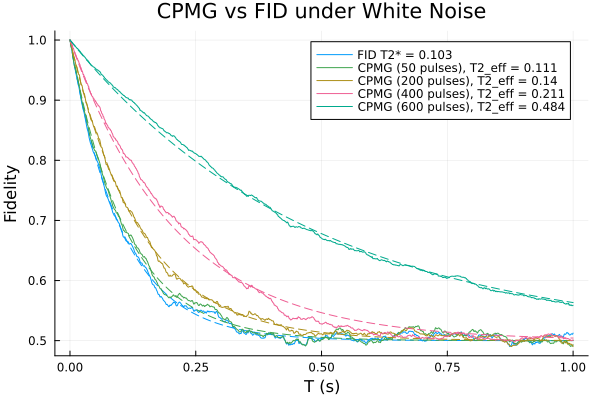

In [6]:
n_pi_pulses = 600
@info "Simulating CPMG with $n_pi_pulses pulses"
control_terms = make_control_terms(sequence, T_max, n_pi_pulses;
        pulse_duration=pulse_duration,
        shape=pulse_shape,
        axis=:x,
        pulse_amplitude=π,
        center_pulse=true
    )

T_vals_ctrl, avg_fid_ctrl = simulate_shaped_control_fidelity(
        ψ₀ = ψ₀,
        T_max = T_max,
        dt = dt,
        target_std = σ,
        n_realizations = n_realizations,
        S_func_z = S_func,
        control_terms = control_terms
    )
fit_ctrl = curve_fit(fit_model, T_vals_ctrl, avg_fid_ctrl, [0.001])
T2_eff = 1/fit_ctrl.param[1]
# plot the fit and the data
@info "T2_eff for CPMG with $n_pi_pulses pulses: $T2_eff"
plot!(plt, T_vals_ctrl, avg_fid_ctrl, label="CPMG ($n_pi_pulses pulses), T2_eff = $( @sprintf("%.3g", T2_eff) )")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(plt, T_vals_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param), linestyle=:dash, label=false, color=c)

┌ Info: Simulating CPMG with 800 pulses
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:2
Simulating 100%|█████████████████████████████████████████| Time: 3:53:49
┌ Info: T2_eff for CPMG with 800 pulses: 2.2696382384764364
└ @ Main c:\Users\vikra\OneDrive\Desktop\project\notebooks\Hahn echo and CPMG\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sZmlsZQ==.jl:23


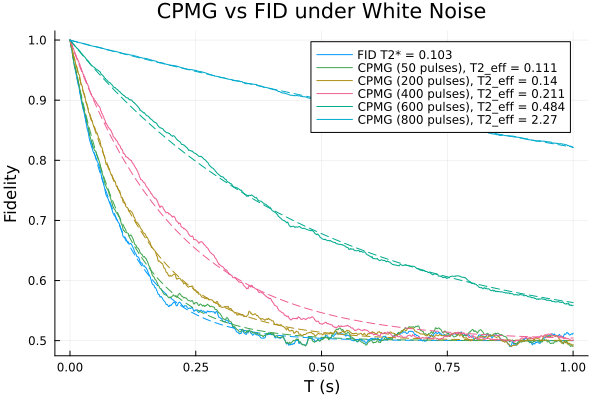

In [7]:
n_pi_pulses = 800
@info "Simulating CPMG with $n_pi_pulses pulses"
control_terms = make_control_terms(sequence, T_max, n_pi_pulses;
        pulse_duration=pulse_duration,
        shape=pulse_shape,
        axis=:x,
        pulse_amplitude=π,
        center_pulse=true
    )

T_vals_ctrl, avg_fid_ctrl = simulate_shaped_control_fidelity(
        ψ₀ = ψ₀,
        T_max = T_max,
        dt = dt,
        target_std = σ,
        n_realizations = n_realizations,
        S_func_z = S_func,
        control_terms = control_terms
    )
fit_ctrl = curve_fit(fit_model, T_vals_ctrl, avg_fid_ctrl, [0.001])
T2_eff = 1/fit_ctrl.param[1]
# plot the fit and the data
@info "T2_eff for CPMG with $n_pi_pulses pulses: $T2_eff"
plot!(plt, T_vals_ctrl, avg_fid_ctrl, label="CPMG ($n_pi_pulses pulses), T2_eff = $( @sprintf("%.3g", T2_eff) )")
c = plt.series_list[end].plotattributes[:seriescolor]
plot!(plt, T_vals_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param), linestyle=:dash, label=false, color=c)

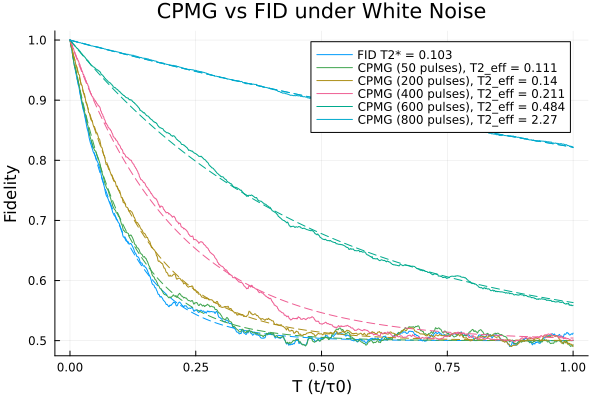

In [8]:
plot!(plt, T_vals_ctrl, fit_model(T_vals_ctrl, fit_ctrl.param), linestyle=:dash, label=false, color=c, xlabel = "T (t/τ0)")